# Coursera Applied Data Science Capstone Project - Week 2

### Forward
Welcome to my coursera Data Science Capstone Project. I am going to create the entire project in this one notebook, so please read all the sections before you grade my notebook for the assignment. This capstone project will be exploring cities and neighborhoods using data to support a decision we will have to make.

## Table of Contents

- Introduction/Business Problem
- Data
- Methodology
- Analysis
- Results and Discussion
- Conclusion

## Introduction/Business Problem

For this project, we have been tasked by a developer to create a map of city's "culinary neighborhoods" to learn more about the restaurant culture in a certain city. Restaurants throughout a city often tell you a lot about the surrounding culture of a neighborhood because people will tend to eat closer to home and want the nearby restaurants to reflect their tastes in food. We will clustering and create our own neighborhoods based on restaraunt location data, then using societal insights we can being to describe and understand the similarities and differences between our created neighborhoods. 

We will be focusing on San Diego, California as our model city. 


## Data



We defined the problem in the previous section, but let's list out the factors we will focus on in this project:
* Neighborhoods and Locations throughout San Diego
* Restaurants and locations throughout the neighborhoods

To define our neighborhoods, we will be mining data from the internet. I have found a Wikipedia page that lists all the different neighborhoods in San Diego.

Following data sources will be needed to extract/generate the required information:
* list of neighborhoods in San Diego will be retrieved from parsing <b>raw text from Wikipedia</b>
* number of restaurants and their type and location in every neighborhood will be obtained using <b>Foursquare API</b>
* coordinate of San Diego and neighborhoods will be obtained using <b>geocode Nominatim</b>

Note: obtaining ratings data requires premium calls to the Foursquare API. Because we are private users, we are only allowed 500 premium calls a day and the code may not work for everyone.

Let's start by importing our necessary libraries.

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import scipy.stats as stats
import pickle
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

Using BeautifulSoup, we will parse the <a href="https://en.wikipedia.org/wiki/List_of_communities_and_neighborhoods_of_San_Diego">Wikipedia link</a> into html text and extract the information from the <b>Table</b> attribute.

In [2]:
#Extract list of neighborhoods from Wikipedia page
wiki_link = 'https://en.wikipedia.org/wiki/List_of_communities_and_neighborhoods_of_San_Diego'
raw_wiki = requests.get(wiki_link).text

#Import and parse the text from Wikipedia using BeautifulSoup
soup = BeautifulSoup(raw_wiki,'lxml')

In [3]:
#Data of the neighborhoods is inside an html <table> object.
soup_table = soup.table
#Decompose the <div> object inside the table to clean our data
soup_table.div.decompose()
soup_table

<table class="multicol" role="presentation" style="border-collapse: collapse; padding: 0; border: 0; background:transparent; width:100%;"><tbody><tr>
<td style="text-align: left; vertical-align: top;">
<ul><li><a class="mw-redirect" href="/wiki/Balboa_Park,_San_Diego" title="Balboa Park, San Diego">Balboa Park</a></li>
<li><a href="/wiki/Bankers_Hill,_San_Diego" title="Bankers Hill, San Diego">Bankers Hill</a></li>
<li><a href="/wiki/Barrio_Logan,_San_Diego" title="Barrio Logan, San Diego">Barrio Logan</a></li>
<li><a class="mw-redirect" href="/wiki/Bay_Ho,_San_Diego" title="Bay Ho, San Diego">Bay Ho</a></li>
<li><a class="mw-redirect" href="/wiki/Bay_Park,_San_Diego" title="Bay Park, San Diego">Bay Park</a></li>
<li><a href="/wiki/Birdland,_San_Diego" title="Birdland, San Diego">Birdland</a></li>
<li><a href="/wiki/Black_Mountain_Ranch,_San_Diego" title="Black Mountain Ranch, San Diego">Black Mountain Ranch</a></li>
<li><a class="mw-redirect" href="/wiki/Border,_San_Diego" title="Bord

In [4]:
#Loop through the soup object to extract names of neighborhoods
neighborhoods = []

for name in soup_table.find_all('a'):
    neighborhoods.append(str(name.string))
    
print('There are',len(neighborhoods),'neighborhoods in San Diego, CA.')

There are 126 neighborhoods in San Diego, CA.


Great! We see that there are 126 neighborhoods found on the Wikipedia page. Now let's use Nominatim to find the GPS locations of each neighborhood.

In [5]:
#import Nominatim to get location data on the neighborhoods
from geopy.geocoders import Nominatim

In [6]:
#from geopy.exc import GeocoderTimedOut #Use this if Geocode 

def locationfinder(neighborhoods):
    geolocator = Nominatim(user_agent='kkha@lab-data.com')
    locations = []
    for nbhd in neighborhoods:
        address = nbhd + ', San Diego, CA'
        location = geolocator.geocode(address)
        if location is None:
            pass
        else:
            x = [nbhd, location.latitude, location.longitude]
            locations.append(x)
    return(locations)

In [7]:
#check if locations pickle created, will load in data if we've already created it before
try:
    with open('locations.pkl', 'rb') as f:
        locations = pickle.load(f)
    print('Data loaded.')
except:
    locations = locationfinder(neighborhoods)
    
#with open('locations.pkl', 'wb') as f:
#    pickle.dump(locations, f)

locations[0:5]

Data loaded.


[['Balboa Park', 32.73135675, -117.146526555704],
 ['Bankers Hill', 32.728293, -117.1621052],
 ['Barrio Logan', 32.6938863, -117.1380068],
 ['Bay Park', 32.7846385, -117.2026047],
 ['Birdland', 32.7923329, -117.1542061]]

Let's create the Dataframe so we can begin to analyze the data.

Through trial and error, we found that not all neighborhoods corresponded to GPS locations in geocode. This was due to overlapping neighborhoods and smaller sectioning of neighborhoods. It is okay to remove out these neighborhoods because our search radius will be large enough to cover missing areas.

In [8]:
df_loc = pd.DataFrame(data=locations)
df_loc.columns = ['Neighborhood', 'Latitude', 'Longitude']

#we see we have NaN values, let's drop these.
df_loc.dropna(axis=0, inplace=True)

Let's begin to map out the neighborhoods just to visualize where we will be working with.

In [42]:
geolocator = Nominatim(user_agent='kevinle.kha@gmail.com')
sd_loc = geolocator.geocode('San Diego, CA')
sd_lat = sd_loc.latitude
sd_lng = sd_loc.longitude

map_SD = folium.Map(location=(sd_lat,sd_lng), zoom_start=10)

for nbhd, lat, lng in zip(df_loc['Neighborhood'], df_loc['Latitude'], df_loc['Longitude']):
    label = '{}, San Diego, CA'.format(nbhd)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=False).add_to(map_SD)
    
map_SD.save(outfile='neighborhood_map.html')
map_SD

You may be wondering why there are no marked neighborhoods between the larger group and smaller group near the border of Mexico. That area is the city of Chula Vista, which does not fall in the jurisdiction of San Diego, therefore is not included in this data.

Awesome! Now that we have the neighborhoods mapped out, let's begin to use our knowledge of Foursquare API to explore restaurant venues from within the neighborhoods. This will help us to fill in data about the types of restaurants and their density within each neighborhood.

In [10]:
#Establish Foursquare credentials and version
CLIENT_ID = 'GBJAVVUEQROJMXHD1NIDQPJX5D1RF3WEBS0Y4JWDC2SCAX5A' # your Foursquare ID
CLIENT_SECRET = 'DYQ4XQKT5OFYARVZB0DJXR3PZ5PEE2R3U5OJ0UB1EDZCVANR' # your Foursquare Secret
VERSION = '20190321' # Foursquare API version

In [11]:
def getNearbyFoods(names, latitudes, longitudes, radius=4000, LIMIT=100):
    
    food_cat = '4d4b7105d754a06374d81259'
    rest_list=[]
    #seen = set()
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT,
            food_cat)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
         
        # return only relevant and unique information for each nearby venue
        for v in results:
            #if v['venue']['name'] not in seen:
                #seen.add(v['venue']['name'])
                rest_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['venue']['id'],
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name'])])

    nearby_foods = pd.DataFrame([item for rest_list in rest_list for item in rest_list])
    nearby_foods.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_foods)

In [12]:
#check if restaurant data pickle created, will load in data if we've already created it before
try:
    with open('sd_rests.pkl', 'rb') as f:
        sd_rests = pickle.load(f)
    print('Data loaded.')
except:
    sd_rests = getNearbyFoods(names=df_loc['Neighborhood'],
                            latitudes = df_loc['Latitude'],
                            longitudes = df_loc['Longitude'])

Data loaded.


In [13]:
sd_rests.to_pickle('sd_rests.pkl')

In [14]:
print('There are {} unique restaurants and {} unique restaurant categories'.format(
    len(sd_rests['Venue'].unique()),
    len(sd_rests['Venue Category'].unique())))

There are 2143 unique restaurants and 95 unique restaurant categories


In [15]:
sd_rests.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue ID', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']

In [16]:
print(sd_rests.shape)
sd_rests.head()

(10623, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Balboa Park,32.731357,-117.146527,4b368637f964a5205f3725e3,The Prado at Balboa Park,32.731042,-117.149792,American Restaurant
1,Balboa Park,32.731357,-117.146527,53bd89e1498e3329fccedb8d,Panama 66,32.731770,-117.151081,Gastropub
2,Balboa Park,32.731357,-117.146527,4d25603c3b62f04d2a732078,CUCINA urbana,32.731278,-117.160189,Italian Restaurant
3,Balboa Park,32.731357,-117.146527,4aab2e6df964a520355920e3,Azuki Sushi,32.729665,-117.160119,Sushi Restaurant
4,Balboa Park,32.731357,-117.146527,4b9af6c7f964a52067e735e3,Mister A's,32.731900,-117.160425,Restaurant


## Methodlogy

In this project, we will begin by extracting a list of all the neighborhoods within San Diego. Wikipedia has a list we can use, so we will parse out the raw HTML text of the website for our benefit using BeautifulSoup. Once the neighborhoods are extracted from the text, we will use Geocoder and the names of the neighborhood to find their latitude and longitude. 

Once we have the locations of each neighborhood, we will begin to work with our Foursquare API. Using the Foursquare API, we will collect all restaurants and the restaurant category within a 4000 meter radius from the location of the Neighborhood. Since we have some neighborhoods that may be closer than 4000 meters, we know there will be restaurants that will be picked up multiple times. We will extract the unique restaurants after we cluster the neighborhoods.

The second step of our analysis will include collecting and summing up all the different types of restaurants within each created cluster. We will then perform Student's T-Test between every cluster to determine the similarity between clusters. Student's T-Test finds the similarity of the means between two samples and determines if they are similar or not. We are looking to describe the similarities between the clusters and want to figure out where the biggest differences lie and where clusters are most similiar for a dining experience. P-values closer to 1 will determine that the clusters are similar and p-values closer to 0 will mean that we reject the hypothesis that the clusters are similar.

Once we finish collecting the p-values, we can then find which restaurant neighborhood clusters are most similar and most dissimilar. 

## Analysis

We begin by performing some exploratory analysis on the data that we have collected from Foursquare.

We will now begin to manipulate the data by using getdummies and get a onehot table so it will be easier for our machine learning algorithms to classify our data.

In [17]:
#one hot encoding
sd_onehot = pd.get_dummies(sd_rests[['Venue Category']], prefix="", prefix_sep="")

#add neighborhoods column back to dataframe
sd_onehot['Neighborhood'] = sd_rests['Neighborhood']

#move neighborhood column to first column
fixed_columns = [sd_onehot.columns[-1]] + list(sd_onehot.columns[:-1])
sd_onehot = sd_onehot[fixed_columns]

#just to make sure we moved the columns correctly
sd_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,...,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Balboa Park,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Balboa Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Balboa Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Balboa Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Balboa Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
sd_grouped = sd_onehot.groupby('Neighborhood').mean().sort_values('Neighborhood').reset_index()
sd_grouped

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,...,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Allied Gardens,0.000000,0.00,0.050000,0.00,0.000000,0.000000,0.020000,0.000000,0.00,...,0.000000,0.00,0.010000,0.060000,0.00,0.00,0.00,0.010000,0.050000,0.020000
1,Alta Vista,0.000000,0.00,0.010000,0.00,0.050000,0.020000,0.000000,0.060000,0.00,...,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.050000,0.030000
2,Balboa Park,0.000000,0.00,0.100000,0.00,0.000000,0.010000,0.000000,0.010000,0.00,...,0.000000,0.00,0.000000,0.040000,0.00,0.00,0.00,0.040000,0.000000,0.000000
3,Bankers Hill,0.000000,0.00,0.100000,0.01,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.000000,0.010000,0.01,0.00,0.00,0.030000,0.000000,0.000000
4,Barrio Logan,0.000000,0.00,0.060000,0.00,0.010000,0.020000,0.000000,0.020000,0.00,...,0.000000,0.01,0.000000,0.020000,0.01,0.00,0.00,0.010000,0.000000,0.000000
5,Bay Park,0.000000,0.00,0.060000,0.00,0.000000,0.020000,0.000000,0.010000,0.00,...,0.000000,0.00,0.010000,0.040000,0.00,0.00,0.00,0.000000,0.020000,0.010000
6,Bay Terraces,0.000000,0.00,0.000000,0.00,0.012658,0.012658,0.000000,0.088608,0.00,...,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.012658,0.025316
7,Birdland,0.000000,0.00,0.070000,0.01,0.000000,0.010000,0.010000,0.040000,0.00,...,0.000000,0.00,0.000000,0.050000,0.00,0.00,0.01,0.020000,0.020000,0.020000
8,Black Mountain Ranch,0.000000,0.00,0.021277,0.00,0.021277,0.021277,0.021277,0.042553,0.00,...,0.000000,0.00,0.000000,0.021277,0.00,0.00,0.00,0.000000,0.021277,0.000000
9,Border,0.000000,0.00,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.00,...,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.010000,0.010000,0.000000


In [19]:
Sum_of_squared_distances = []
sd_grouped_clustering = sd_grouped.drop('Neighborhood', 1)

K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(sd_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

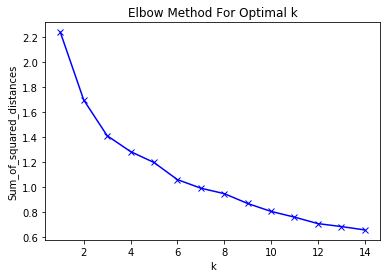

In [20]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In our Elbow method, we see that K will continuously decrease so we will  set cluster limit to 4. That is when the changes sum of squared distances becomes negligible as we increase K.

In [21]:
#set number of clusters
kclusters = 10

#run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sd_grouped_clustering)

kmeans.labels_[0:10]

array([1, 5, 9, 0, 8, 2, 5, 3, 4, 2])

In [22]:
#Apply the cluster labels to our original location dataframe
sd_clustered = df_loc.sort_values('Neighborhood').reset_index(drop=True)
sd_clustered['Cluster Labels'] = kmeans.labels_

sd_clustered.head()

,Neighborhood,Latitude,Longitude,Cluster Labels
0,Allied Gardens,32.792687,-117.080436,1
1,Alta Vista,32.693339,-117.063154,5
2,Balboa Park,32.731357,-117.146527,9
3,Bankers Hill,32.728293,-117.162105,0
4,Barrio Logan,32.693886,-117.138007,8


We are now going to map out the neighborhoods and color them for easier visualization of the grouping.

In [45]:
# create map
map_clusters = folium.Map(location=[sd_lat, sd_lng], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.jet(np.linspace(0, 1, len(ys)))
jet = [colors.to_hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sd_clustered['Latitude'], sd_clustered['Longitude'], sd_clustered['Neighborhood'], sd_clustered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=jet[cluster-1],
        fill=True,
        fill_color=jet[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save(outfile='cluster_map.html')
map_clusters

In [24]:
#Find the count of neighborhoods within each cluster to see how our model worked
sd_clustered[['Neighborhood','Cluster Labels']].groupby('Cluster Labels').count()

,Neighborhood
Cluster Labels,
0,13
1,14
2,20
3,5
4,5
5,21
6,1
7,10
8,10


It looks like Cluster 5 has the most neighborhoods with 21 and Cluster 6 has the least with only 1 neighborhood. Cluster 6 is much further away from the other clusters, therefore it is reasonable that it only include 1 other cluster. Cluster 5 has the largest amount of neighborhoods but also spans a must larger area. We can understand this as the restaurant diversity of those separated groups is roughly the same, therefore it is reasonable to cluster them together as one.

Now that we have our neighborhoods clustered, let's dive into each cluster and do some statistical testing to find out the similarity of the clusters.

In [25]:
#Create a new dataframe of only Neighborhood, Venue data, and Cluster Labels
sd_rests_cat = pd.DataFrame(data=sd_rests[['Neighborhood','Venue ID','Venue','Venue Latitude', 'Venue Longitude', 'Venue Category']])

#Create a dictionary that maps each neighborhood to its assigned cluster from K-Means
cluster_nbhd = sd_clustered[['Neighborhood', 'Cluster Labels']]
nbhd_cluster_dict = dict(zip(cluster_nbhd['Neighborhood'], cluster_nbhd['Cluster Labels']))
nbhd_cluster_dict

#Map the dictionary to our new dataframe
sd_rests_cat['Cluster Labels'] = sd_rests_cat['Neighborhood'].map(nbhd_cluster_dict)
sd_rests_cat.head()

,Neighborhood,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
0,Balboa Park,4b368637f964a5205f3725e3,The Prado at Balboa Park,32.731042,-117.149792,American Restaurant,9
1,Balboa Park,53bd89e1498e3329fccedb8d,Panama 66,32.731770,-117.151081,Gastropub,9
2,Balboa Park,4d25603c3b62f04d2a732078,CUCINA urbana,32.731278,-117.160189,Italian Restaurant,9
3,Balboa Park,4aab2e6df964a520355920e3,Azuki Sushi,32.729665,-117.160119,Sushi Restaurant,9
4,Balboa Park,4b9af6c7f964a52067e735e3,Mister A's,32.731900,-117.160425,Restaurant,9


In [26]:
#list to span numbered clusters
c_list = list(np.arange(0,kclusters,1))

#dictionary of dataframes to separate out restaurants by cluster
d = {c: pd.DataFrame() for c in c_list}

# d[#] where # means the numbered cluster to make our data more easily understood
for c in c_list:
    d[c] = sd_rests_cat.loc[sd_rests_cat['Cluster Labels'] == c].drop(['Cluster Labels'],1).reset_index(drop=True)

What wasn't readily understood at the beginning was that our explore call was collecting duplicate restaurants when the search radius overlapped through neighborhoods. This will clean the data to only include unique restaurants and have each restaurant appear only once per cluster.

In [27]:
def get_unique_rests(data):

    unique_list = []
    seen = set()

    for i in range(0,data.shape[0]):
        if data['Venue ID'][i] not in seen:
            seen.add(data['Venue ID'][i])
            unique_list.append(data.iloc[i])
        
        df_unique = pd.DataFrame(data=unique_list).reset_index(drop=True)
    return(df_unique)

In [28]:
c = {c: pd.DataFrame() for c in c_list}
for x in c_list:
    c[x] = get_unique_rests(d[x]) 

In [29]:
c[0].head()

,Neighborhood,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bankers Hill,4aab2e6df964a520355920e3,Azuki Sushi,32.729665,-117.160119,Sushi Restaurant
1,Bankers Hill,4bf49fe494af2d7f96e23a72,Bankers Hill Bar & Restaurant,32.728456,-117.161419,American Restaurant
2,Bankers Hill,4d25603c3b62f04d2a732078,CUCINA urbana,32.731278,-117.160189,Italian Restaurant
3,Bankers Hill,4b9af6c7f964a52067e735e3,Mister A's,32.731900,-117.160425,Restaurant
4,Bankers Hill,4b21d92df964a520f24124e3,The Market Place,32.732659,-117.160044,Deli / Bodega


In [30]:
cf = {x: pd.DataFrame() for x in c_list}

for x in c_list:
    cf[x] = c[x][['Venue','Venue Category']].groupby('Venue Category').count()

In [31]:
from functools import reduce

cfct = reduce(lambda x,y: pd.merge(x,y, on='Venue Category', how='outer'), [cf[x] for x in c_list])

In [32]:
string = 'Cluster '
clusters = list(map(str, range(0, kclusters)))
cluster_list = [string + c for c in clusters]

In [33]:
cfct.columns = cluster_list
cfct.fillna(value=0, inplace=True)
cfct.head()

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9
Venue Category,,,,,,,,,,
American Restaurant,19.0,20.0,34.0,10.0,6.0,9.0,1.0,10.0,22.0,45.0
Argentinian Restaurant,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
Asian Restaurant,2.0,7.0,6.0,3.0,3.0,12.0,0.0,12.0,5.0,4.0
BBQ Joint,2.0,8.0,9.0,3.0,3.0,10.0,0.0,5.0,3.0,4.0
Bakery,4.0,11.0,15.0,8.0,5.0,21.0,0.0,13.0,4.0,10.0


Using the Student's T-test, we found the p-values between each of the clusters to find the similarity bewteen the clusters. T-testing requires one to understand the null hypothesis that two sample means are the same. If the p-value is closer to 1, we can accept the null hypothesis which means the mean of the clusters are similar. Alternately, if the p-value is closer to 0, we can reject the null hypothesis, which means that the mean of the two clusters are NOT similar (they are different).


In [34]:
p = []
pl = {}

for i in c_list:
    for j in c_list:
        p.append(stats.ttest_ind(cf[i],cf[j]).pvalue[0])
    pl[i] = p
    p=[]
    
pl_df = pd.DataFrame(pl)
pl_df

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.070951,0.028304,0.147732,0.276039,0.068933,0.076455,0.365497,0.900982,0.223049
1,0.070951,1.000000,0.531415,0.002447,0.018772,0.463542,0.063446,0.250614,0.044776,0.397468
2,0.028304,0.531415,1.000000,0.000968,0.010469,0.805797,0.064961,0.084004,0.016027,0.149264
3,0.147732,0.002447,0.000968,1.000000,0.812713,0.008709,0.067492,0.022556,0.173047,0.008536
4,0.276039,0.018772,0.010469,0.812713,1.000000,0.043431,0.024471,0.081406,0.315039,0.041976
5,0.068933,0.463542,0.805797,0.008709,0.043431,1.000000,0.162794,0.117735,0.046285,0.179188
6,0.076455,0.063446,0.064961,0.067492,0.024471,0.162794,1.000000,0.075303,0.074534,0.056097
7,0.365497,0.250614,0.084004,0.022556,0.081406,0.117735,0.075303,1.000000,0.284018,0.739651
8,0.900982,0.044776,0.016027,0.173047,0.315039,0.046285,0.074534,0.284018,1.000000,0.161162
9,0.223049,0.397468,0.149264,0.008536,0.041976,0.179188,0.056097,0.739651,0.161162,1.000000


Comparing a cluster to itself will be 1 (since the means are the same if you compare the same set), so we will drop those values by making them NULL or NaN.

In [35]:
for i in c_list:
    pl_df[i][i] = np.NaN
    
pl_df

,0,1,2,3,4,5,6,7,8,9
0,NaN,0.070951,0.028304,0.147732,0.276039,0.068933,0.076455,0.365497,0.900982,0.223049
1,0.070951,NaN,0.531415,0.002447,0.018772,0.463542,0.063446,0.250614,0.044776,0.397468
2,0.028304,0.531415,NaN,0.000968,0.010469,0.805797,0.064961,0.084004,0.016027,0.149264
3,0.147732,0.002447,0.000968,NaN,0.812713,0.008709,0.067492,0.022556,0.173047,0.008536
4,0.276039,0.018772,0.010469,0.812713,NaN,0.043431,0.024471,0.081406,0.315039,0.041976
5,0.068933,0.463542,0.805797,0.008709,0.043431,NaN,0.162794,0.117735,0.046285,0.179188
6,0.076455,0.063446,0.064961,0.067492,0.024471,0.162794,NaN,0.075303,0.074534,0.056097
7,0.365497,0.250614,0.084004,0.022556,0.081406,0.117735,0.075303,NaN,0.284018,0.739651
8,0.900982,0.044776,0.016027,0.173047,0.315039,0.046285,0.074534,0.284018,NaN,0.161162
9,0.223049,0.397468,0.149264,0.008536,0.041976,0.179188,0.056097,0.739651,0.161162,NaN


In [36]:
# idxmax() will find the index of the maximum of that column/row
max_list = pl_df.idxmax()
# idxmin() will find the index of the minimum of that column/row
min_list = pl_df.idxmin()

In [37]:
for i in c_list:
    print('For Cluster',i,': The most similar Cluster is',max_list[i],'with a p-value of', pl_df.max()[i])

For Cluster 0 : The most similar Cluster is 8 with a p-value of 0.9009823847375997
For Cluster 1 : The most similar Cluster is 2 with a p-value of 0.5314150702810454
For Cluster 2 : The most similar Cluster is 5 with a p-value of 0.8057966625128942
For Cluster 3 : The most similar Cluster is 4 with a p-value of 0.8127133207937982
For Cluster 4 : The most similar Cluster is 3 with a p-value of 0.8127133207937982
For Cluster 5 : The most similar Cluster is 2 with a p-value of 0.8057966625128942
For Cluster 6 : The most similar Cluster is 5 with a p-value of 0.16279449893453732
For Cluster 7 : The most similar Cluster is 9 with a p-value of 0.7396514268932144
For Cluster 8 : The most similar Cluster is 0 with a p-value of 0.9009823847375997
For Cluster 9 : The most similar Cluster is 7 with a p-value of 0.7396514268932144


In [38]:
print('Cluster',pl_df.max().idxmax(), 'has the largest p-value and is most similar to Cluster 8 with a p-value of',pl_df.max().max())

Cluster 0 has the largest p-value and is most similar to Cluster 8 with a p-value of 0.9009823847375997


In [39]:
for i in c_list:
    print('For Cluster',i,': The most dissimilar Cluster is',min_list[i],'with a p-value of', pl_df.min()[i])

For Cluster 0 : The most dissimilar Cluster is 2 with a p-value of 0.02830416948037709
For Cluster 1 : The most dissimilar Cluster is 3 with a p-value of 0.002446500704030295
For Cluster 2 : The most dissimilar Cluster is 3 with a p-value of 0.0009677798877580568
For Cluster 3 : The most dissimilar Cluster is 2 with a p-value of 0.0009677798877580568
For Cluster 4 : The most dissimilar Cluster is 2 with a p-value of 0.010469306577866874
For Cluster 5 : The most dissimilar Cluster is 3 with a p-value of 0.008709340480620333
For Cluster 6 : The most dissimilar Cluster is 4 with a p-value of 0.02447142285204613
For Cluster 7 : The most dissimilar Cluster is 3 with a p-value of 0.022555576142853393
For Cluster 8 : The most dissimilar Cluster is 2 with a p-value of 0.0160270207875338
For Cluster 9 : The most dissimilar Cluster is 3 with a p-value of 0.008536266785275552


In [40]:
print('Cluster',pl_df.min().idxmin(), 'has the lowest p-value and is most dissimilar to Cluster 3 with a p-value of',pl_df.min().min())

Cluster 2 has the lowest p-value and is most dissimilar to Cluster 3 with a p-value of 0.0009677798877580568


## Results and Discussion

Our analysis has shown that there are a lot of restaurants in San Diego! Over 2500 unique restaurants were identified and subsequently used to cluster our culinary neighborhoods in San Diego. From visual analysis, the largest density of neighborhoods was in Cluster 8 while the largest cluster was Cluster 5 with 21 neighborhoods. 

It is interesting that Clusters 0 and 8 are the most similar, and they are the closest together on the map. We can take this to mean that although there may be slight differences between the two clusters, they are relatively the same and only differ by geographical location. You may be able to go from one cluster, or culinary neighborhood, to the other and expect to see the same types of restaurants.

The further away from downtown we go, the more separated the neighborhoods are. This is expected because those outer laying neighborhoods are suburbs and the density of restaurants decreases due to the higher density of residential housing. It would be sufficient to collect these neighborhoods together as clusters because each neighborhood would cater to the average person's palate. The seemingly unconscious societal decision to have a normal distribution of popular foods in less restaurant dense clusters describes what a population of people in those neighborhoods wants to eat! So we may assume that the larger the area spanned by a cluster, the more similar the restaurants within each cluster and the more similar the foods that the population of the clusters would want to eat.

## Conclusion

We were tasked with the project of creating a map of "culinary neighborhoods" within a chosen city. By mapping out the neighborhoods of San Diego and then using the Foursquare API to collect all the restaurants within the city, we were able to cluster neighborhoods together to create larger culinary neighborhoods. The visualizations and analysis done to the clusters and restaurants gives us insight into the tastebuds of certain neighborhoods and the culinary palate that each cluster or neighborhood prefers.

I would love to expand on this project by obtaining popularity data of each restaurant within the cluster and doing more statistical analysis on where popular restaurants are versus what kinds of restaurants are present in each cluster. 